
# This Notebook is a sort of tutorial for the beginners in Deep Learning and time-series data analysis.

### * The aim is just to show how to build the simplest Long short-term memory (LSTM) recurrent neural network for the data.  

### The description of data can be found here:
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

### Attribute Information:

#### 1.date: Date in format dd/mm/yyyy
#### 2.time: time in format hh:mm:ss
#### 3.global_active_power: household global minute-averaged active power (in kilowatt)
#### 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
#### 5.voltage: minute-averaged voltage (in volt)
#### 6.global_intensity: household global minute-averaged current intensity (in ampere)
#### 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
#### 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
#### 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


In [3]:
# Let`s import all packages that we may need:

import sys
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers import Conv1D, MaxPooling1D  # updated import for convolutional layers
from keras.layers import Dropout


# Importing the data and data processing

In [4]:
## Data can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
## Just open the zip file and grab the file 'household_power_consumption.txt' put it in the directory
## that you would like to run the code.

df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')

<ipython-input-4-e9dcf0c4ce2a>:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-4-e9dcf0c4ce2a>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-4-e9dcf0c4ce2a>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


### 1) Note that data include 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same.

### 2) I merged two columns 'Date' and 'Time' to 'dt'.

### 3) I also converted in the above, the data to time-series type, by taking index to be the time.

In [5]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229674 entries, 2006-12-16 17:24:00 to 2007-05-25 05:17:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    225942 non-null  float64
 1   Global_reactive_power  225942 non-null  float64
 2   Voltage                225942 non-null  float64
 3   Global_intensity       225942 non-null  float64
 4   Sub_metering_1         225941 non-null  float64
 5   Sub_metering_2         225941 non-null  float64
 6   Sub_metering_3         225941 non-null  float64
dtypes: float64(7)
memory usage: 14.0 MB


In [7]:
df.dtypes

,0
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


In [8]:
df.shape

(229674, 7)

In [9]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,225942.000000,225942.000000,225942.000000,225942.000000,225941.000000,225941.000000,225941.000000
mean,1.305536,0.120690,239.675234,5.549636,1.272558,1.727978,6.292970
std,1.253405,0.111099,3.666330,5.293912,6.554234,6.949359,8.355427
min,0.104000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.312000,0.000000,237.110000,1.400000,0.000000,0.000000,0.000000
50%,0.912000,0.104000,239.990000,4.000000,0.000000,0.000000,0.000000
75%,1.876000,0.188000,242.300000,8.000000,0.000000,1.000000,17.000000
max,10.670000,0.988000,251.700000,46.400000,77.000000,78.000000,20.000000


In [10]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [11]:
for j in range(1,7):
       print(df.iloc[:, j].unique())

[0.418 0.436 0.498 0.502 0.528 0.522 0.52  0.51  0.47  0.478 0.398 0.422
 0.282 0.152 0.156 0.    0.076 0.09  0.2   0.058 0.18  0.144 0.118 0.108
 0.202 0.192 0.186 0.116 0.136 0.148 0.16  0.158 0.1   0.082 0.05  0.052
 0.162 0.086 0.048 0.054 0.068 0.166 0.174 0.178 0.188 0.088 0.08  0.07
 0.084 0.074 0.106 0.092 0.064 0.046 0.138 0.134 0.132 0.12  0.13  0.154
 0.078 0.142 0.14  0.146 0.15  0.17  0.102 0.072 0.06  0.056 0.062 0.112
 0.066 0.172 0.168 0.194 0.184 0.096 0.164 0.182 0.094 0.098 0.176 0.19
 0.204 0.22  0.198 0.208 0.244 0.334 0.298 0.296 0.286 0.278 0.104 0.258
 0.238 0.256 0.214 0.23  0.21  0.24  0.124 0.122 0.27  0.302 0.272 0.25
 0.294 0.3   0.128 0.126 0.234 0.242 0.316 0.28  0.288 0.224 0.11  0.248
 0.254 0.222 0.246 0.216 0.212 0.114 0.206 0.228 0.226 0.196 0.218 0.368
 0.338 0.31  0.304 0.292 0.268 0.266 0.26  0.396 0.38  0.4   0.384 0.416
 0.404 0.382 0.232 0.314 0.312 0.262 0.252 0.236 0.348 0.342 0.34  0.35
 0.504 0.344 0.346 0.366 0.574 0.582 0.37  0.364 0.36  

#  Dealing with missing values  'nan' with a test statistic

In [12]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [13]:
# filling nan with mean in any columns

for j in range(0,7):
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())


In [14]:
# another sanity check to make sure that there are not more any nan
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [15]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,229674.000000,229674.000000,229674.000000,229674.000000,229674.000000,229674.000000,229674.000000
mean,1.305536,0.120690,239.675234,5.549636,1.272558,1.727978,6.292970
std,1.243180,0.110193,3.636421,5.250725,6.500751,6.892652,8.287247
min,0.104000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.314000,0.000000,237.170000,1.400000,0.000000,0.000000,0.000000
50%,1.002000,0.106000,239.910000,4.400000,0.000000,0.000000,0.000000
75%,1.852000,0.184000,242.260000,7.800000,0.000000,1.000000,17.000000
max,10.670000,0.988000,251.700000,46.400000,77.000000,78.000000,20.000000


In [16]:
df['Global_active_power'].resample('M').sum()

<ipython-input-16-527eef9bcd7f>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Global_active_power'].resample('M').sum()


,Global_active_power
dt,
2006-12-31,41818.504145
2007-01-31,69014.473072
2007-02-28,56491.497072
2007-03-31,58863.497536
2007-04-30,40041.977403
2007-05-31,33617.780000


# Data visualization


### * Below I resample over day, and show the sum and mean of Global_active_power. It is seen that mean and sum of resampled data set, have similar structure.

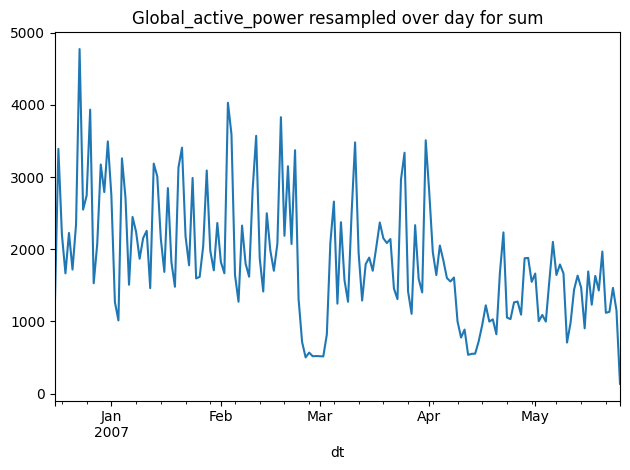

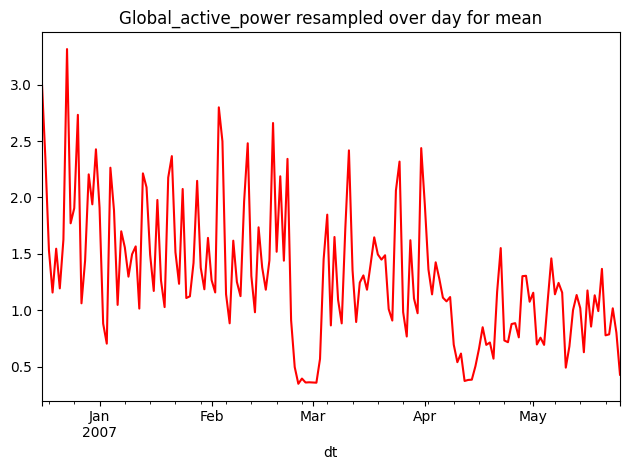

In [17]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red')
plt.tight_layout()
plt.show()

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red')
plt.tight_layout()
plt.show()

### Below I show mean and std of 'Global_intensity' resampled over day

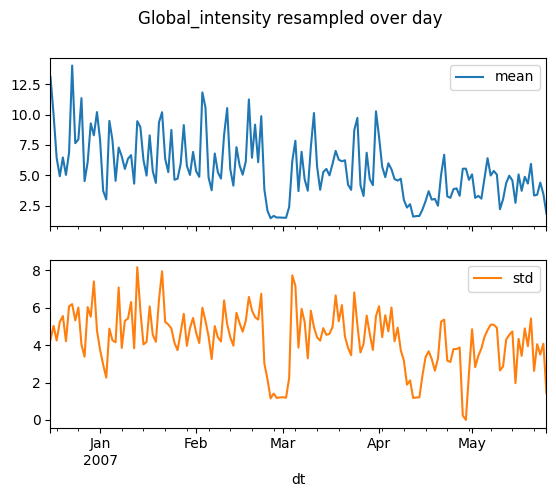

In [18]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

### Below I show mean and std of 'Global_reactive_power' resampled over day

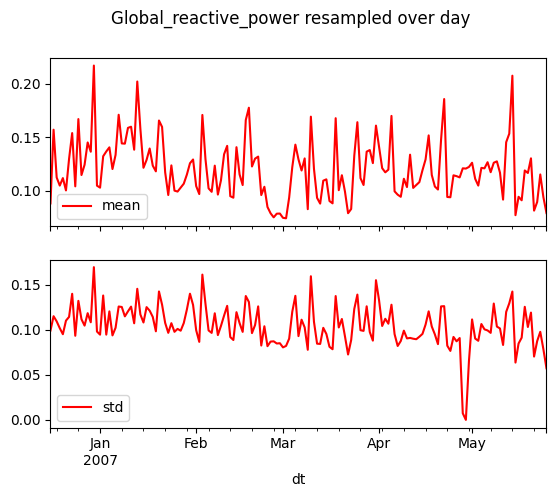

In [19]:
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

### Sum of 'Global_active_power' resampled over month

<ipython-input-20-9634fd98a7d7>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Global_active_power'].resample('M').mean().plot(kind='bar')


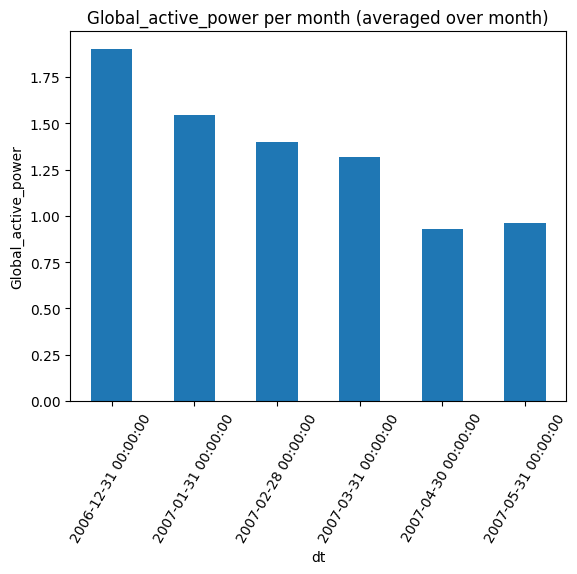

In [20]:
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

## Mean of 'Global_active_power' resampled over quarter

<ipython-input-21-a442b7662d0e>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df['Global_active_power'].resample('Q').mean().plot(kind='bar')


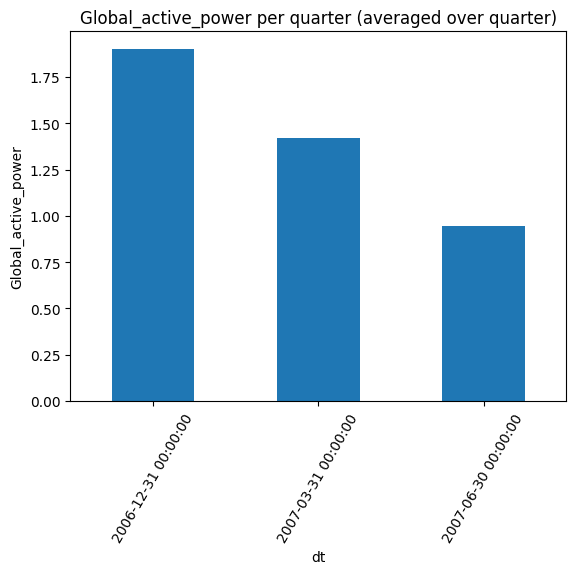

In [21]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

### * It is very important to note from above two plots that resampling over larger time inteval, will diminish the periodicity of system as we expect. This is important for machine learning feature engineering.

## mean of 'Voltage' resampled over month

<ipython-input-22-c29e5aa3da37>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Voltage'].resample('M').mean().plot(kind='bar', color='red')


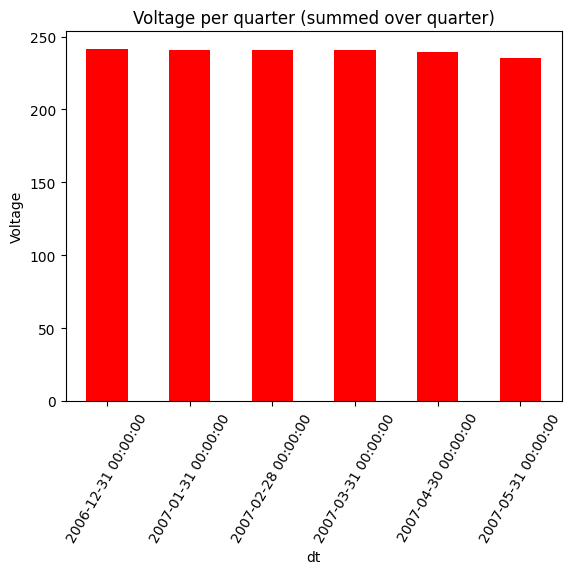

In [22]:
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

<ipython-input-23-7ed25db45c7c>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')


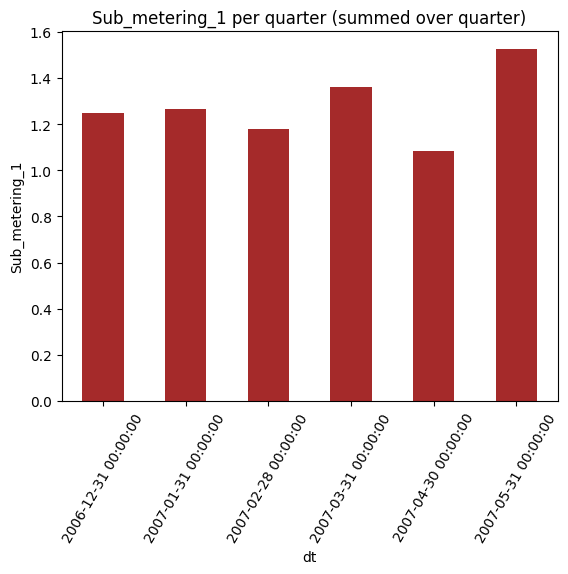

In [23]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

### * It is seen from the above plots that the mean of 'Volage' over month is pretty much constant compared to other features. This is important again in feature selection.  

# Below I compare the mean of different features resampled over day.

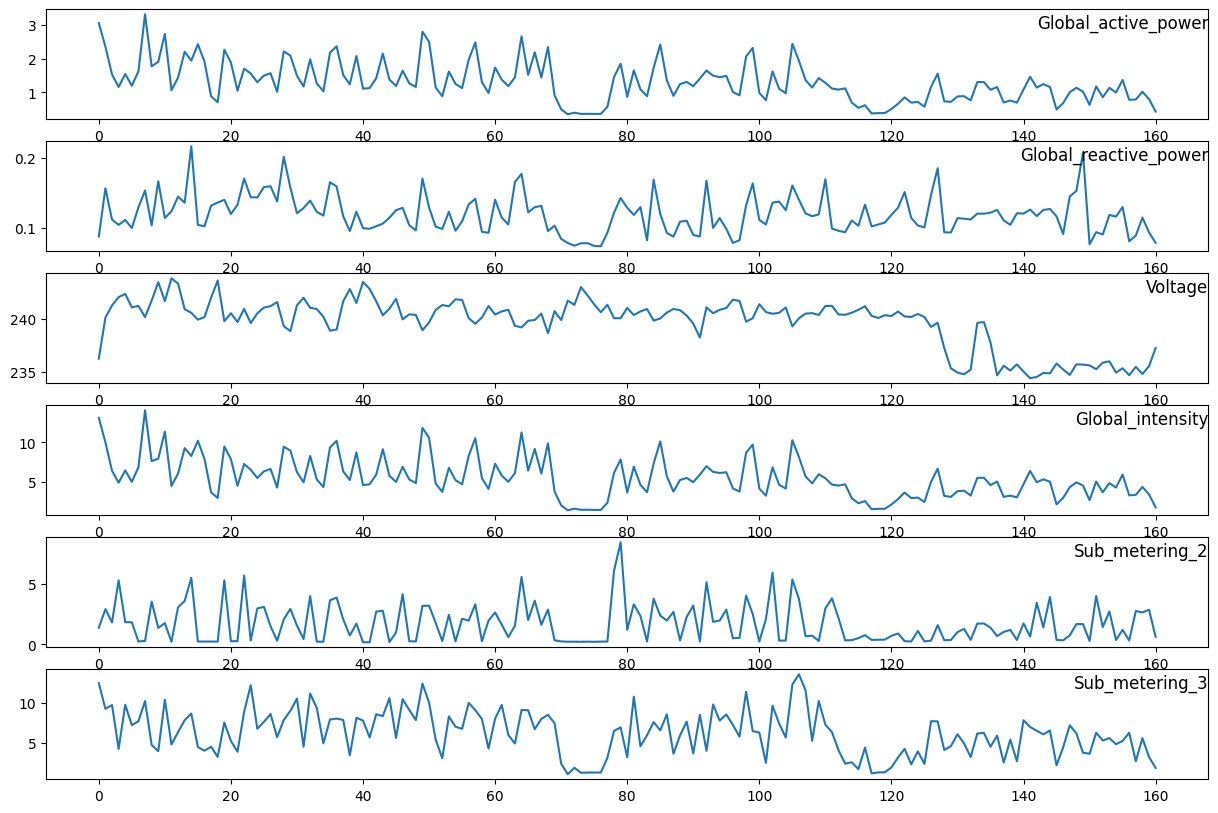

In [24]:
# Below I compare the mean of different featuresresampled over day.
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

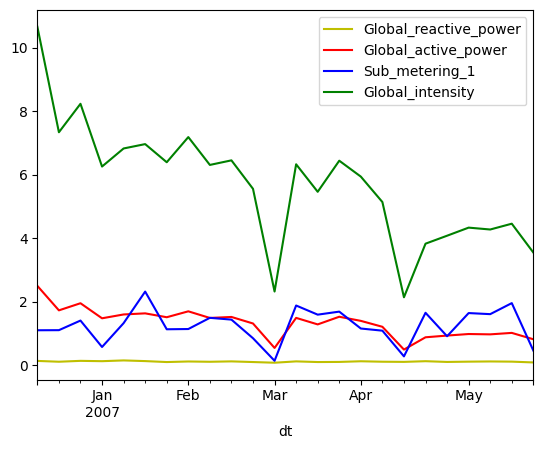

In [25]:
## resampling over week and computing mean
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

<ipython-input-26-e0f3b0bcd48d>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
<ipython-input-26-e0f3b0bcd48d>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
<ipython-input-26-e0f3b0bcd48d>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
<ipython-input-26-e0f3b0bcd48d>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)


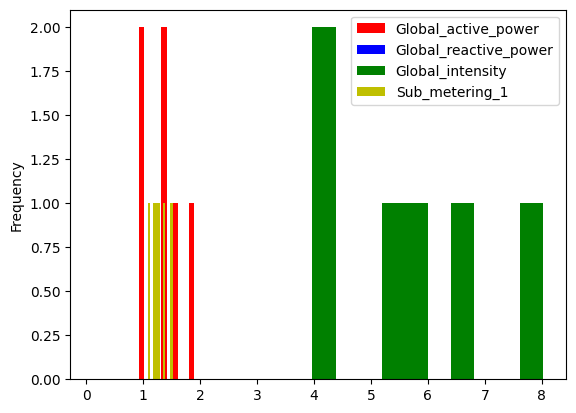

In [26]:
# Below I show hist plot of the mean of different feature resampled over month
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
#df.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

## The correlations between 'Global_intensity' and  'Global_active_power'

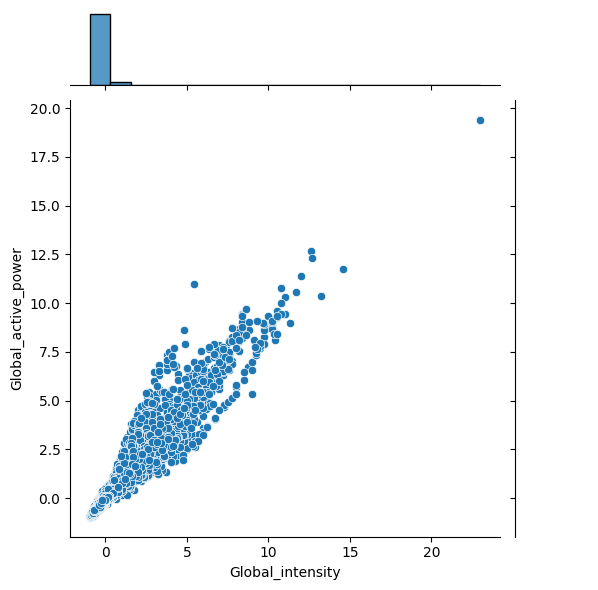

In [27]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)

plt.show()

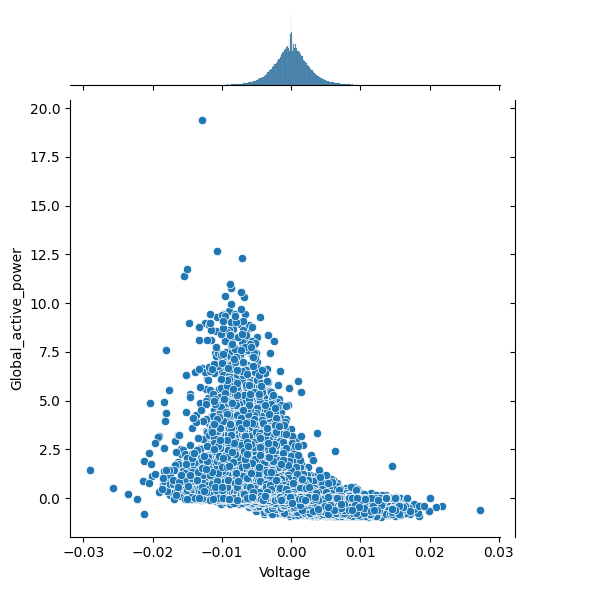

In [28]:
## The correlations between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)
plt.show()

### * From above two plots it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated. This is important observation for machine learning purpose.

# Correlations among features

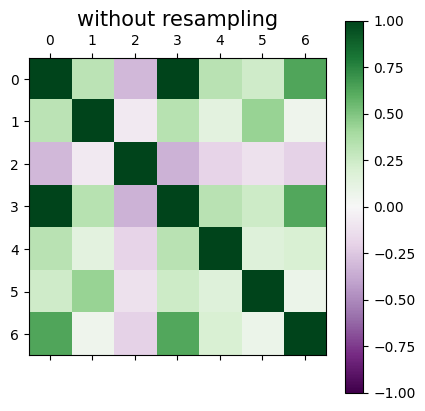

In [29]:
# Correlations among columns
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

# Correlations of mean of resampled features

<ipython-input-30-f78a22ef2e11>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
<ipython-input-30-f78a22ef2e11>:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')


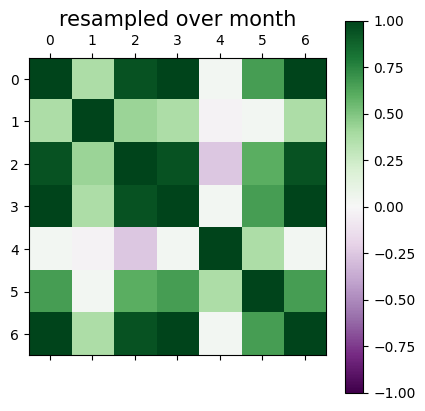

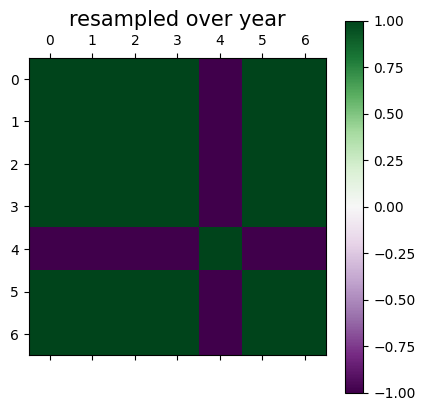

In [30]:
# Correlations of mean of features resampled over months


plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

### * It is seen from above that with resampling techniques one can change the correlations among features. This is important for feature  engineering.

# Machine-Leaning: LSTM Data Preparation and feature engineering

### * I will apply recurrent nueral network (LSTM) which is best suited for time-seriers and sequential problem. This approach is the best if we have large data.  

### * I will frame the supervised learning problem as predicting the Global_active_power at the current time (t) given the Global_active_power measurement and other features at the prior time step.

In [31]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


### * In order to reduce the computation time, and also get a quick result to test the model.  One can resmaple the data over hour (the original data are given in minutes). This will reduce the size of data from 2075259 to 34589 but keep the overall strucure of data as shown in the above.   

In [32]:
## resampling of data over hour
df_resample = df.resample('h').mean()
df_resample.shape

(3829, 7)

## * Note: I scale all features in range of [0,1].

In [33]:
## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.654709   0.375233   0.264248   0.643308        0.0   0.013178   
2   0.559444   0.106453   0.261262   0.550452        0.0   0.167707   
3   0.522033   0.115836   0.198100   0.509719        0.0   0.035789   
4   0.500798   0.097552   0.237422   0.487929        0.0   0.000000   
5   0.466591   0.100379   0.382109   0.455615        0.0   0.010404   

   var7(t-1)   var1(t)  
1   0.897663  0.559444  
2   0.897959  0.522033  
3   0.888199  0.500798  
4   0.893523  0.466591  
5   0.916593  0.328484  


### * Above I showed 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current  time in hour (depending on resampling).

# Splitting the rest of data to train and validation sets

### * First, I split the prepared dataset into train and test sets. To speed up the training of the model (for the sake of the demonstration), we will only train the model on the first year of data, then evaluate it on the next 3 years of data.

In [34]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(3828, 1, 7) (3828,) (0, 1, 7) (0,)


In [35]:
# split into train and test sets
values = reframed.values

# Updated split to 80% train, 20% test
n_train_time = int(len(values) * 0.8)  # Use 80% of data for training
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3062, 1, 7) (3062,) (766, 1, 7) (766,)


# Model architecture

### 1)  LSTM with 100 neurons in the first visible layer
### 3) dropout 20%
### 4) 1 neuron in the output layer for predicting Global_active_power.
### 5) The input shape will be 1 time step with 7 features.

### 6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
### 7) The model will be fit for 20 training epochs with a batch size of 70.



Before reshape → train_X: ndim=3, shape=(3062, 1, 7)
Before reshape → test_X:  ndim=3,  shape=(766, 1, 7)
After reshape  → train_X: (3062, 1, 7), test_X: (766, 1, 7)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
48/48 - 4s - 84ms/step - loss: 0.0334 - val_loss: 0.0107
Epoch 2/30
48/48 - 2s - 51ms/step - loss: 0.0186 - val_loss: 0.0095
Epoch 3/30
48/48 - 0s - 7ms/step - loss: 0.0166 - val_loss: 0.0092
Epoch 4/30
48/48 - 0s - 6ms/step - loss: 0.0152 - val_loss: 0.0089
Epoch 5/30
48/48 - 0s - 6ms/step - loss: 0.0144 - val_loss: 0.0088
Epoch 6/30
48/48 - 0s - 6ms/step - loss: 0.0137 - val_loss: 0.0087
Epoch 7/30
48/48 - 0s - 6ms/step - loss: 0.0132 - val_loss: 0.0087
Epoch 8/30
48/48 - 0s - 7ms/step - loss: 0.0132 - val_loss: 0.0087
Epoch 9/30
48/48 - 0s - 6ms/step - loss: 0.0132 - val_loss: 0.0088
Epoch 10/30
48/48 - 0s - 8ms/step - loss: 0.0128 - val_loss: 0.0088
Epoch 11/30
48/48 - 1s - 13ms/step - loss: 0.0129 - val_loss: 0.0088
Epoch 12/30
48/48 - 1s - 15ms/step - loss: 0.0130 - val_loss: 0.0086
Epoch 13/30
48/48 - 0s - 10ms/step - loss: 0.0130 - val_loss: 0.0087
Epoch 14/30
48/48 - 0s - 9ms/step - loss: 0.0129 - val_loss: 0.0087
Epoch 15/30
48/48 - 0s - 6ms/step - loss: 0.0128 - v

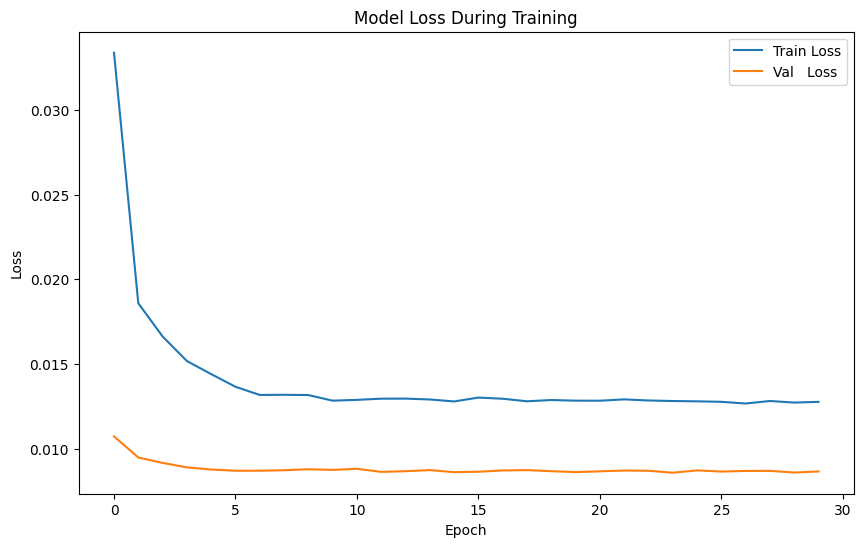

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test RMSE: 0.577


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error

# 0) DEBUG: inspect before any reshape
print(f"Before reshape → train_X: ndim={train_X.ndim}, shape={train_X.shape}")
print(f"Before reshape → test_X:  ndim={test_X.ndim},  shape={test_X.shape}")

# 1) Determine timesteps & features from train_X, reshape train_X if 2D
if train_X.ndim == 2:
    # originally [samples, features]
    n_timesteps = 1
    n_features  = train_X.shape[1]
    train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
elif train_X.ndim == 3:
    n_timesteps, n_features = train_X.shape[1], train_X.shape[2]
else:
    raise ValueError(f"train_X must be 2D or 3D; got ndim={train_X.ndim}")

# 2) Ensure test_X is also 3D with same timesteps & features
if test_X.ndim == 2:
    test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))
elif test_X.ndim == 3:
    if test_X.shape[1:] != (n_timesteps, n_features):
        raise ValueError(f"test_X has shape {test_X.shape[1:]}, expected ({n_timesteps},{n_features})")
else:
    raise ValueError(f"test_X must be 2D or 3D; got ndim={test_X.ndim}")

print(f"After reshape  → train_X: {train_X.shape}, test_X: {test_X.shape}")

# 3) Hyperparameters
epochs     = 30
batch_size = 64

# 4) Build & compile
model = Sequential([
    LSTM(100, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

# 5) Train
history = model.fit(
    train_X, train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False
)

# 6) Plot loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],     label='Train Loss')
plt.plot(history.history['val_loss'], label='Val   Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

# 7) Predict & invert scaling
yhat = model.predict(test_X)

# flatten [samples, timesteps, features] → [samples, timesteps*features]
flat_X = test_X.reshape((test_X.shape[0], n_timesteps * n_features))

# invert predictions
inv_yhat = np.concatenate(
    (yhat, flat_X[:, -(n_features-1):]),
    axis=1
)
inv_yhat = scaler.inverse_transform(inv_yhat)[:,0]

# invert ground truth
true_y = test_y.reshape((len(test_y), 1))
inv_y  = np.concatenate(
    (true_y, flat_X[:, -(n_features-1):]),
    axis=1
)
inv_y = scaler.inverse_transform(inv_y)[:,0]

# 8) Evaluate
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(f"Test RMSE: {rmse:.3f}")


In [37]:
!pip install keras-tuner -q # Install Keras Tuner if not already installed
import keras_tuner as kt

def model_builder(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                   return_sequences=True, # Return sequences for stacking LSTM layers
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32)))  # Additional LSTM layer
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation=hp.Choice('activation', values=['relu', 'linear']))) # tune activation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(train_X, train_y, epochs=50, validation_data=(test_X, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it fully
model = tuner.hypermodel.build(best_hps)

# Define epochs and batch_size explicitly
epochs = 50  # or any desired value
batch_size = 64 # or any desired value


history = model.fit(train_X, train_y, epochs=epochs, # Use the defined epochs variable here
                    batch_size=batch_size, # Use the defined batch_size variable here
                    validation_data=(test_X, test_y))

Trial 90 Complete [00h 00m 49s]
val_loss: 0.008421909995377064

Best val_loss So Far: 0.008082635700702667
Total elapsed time: 00h 18m 38s
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0435 - val_loss: 0.0107
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0177 - val_loss: 0.0103
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - val_loss: 0.0096
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0135 - val_loss: 0.0090
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0132 - val_loss: 0.0095
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0125 - val_loss: 0.0110
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - val_loss: 0.0094
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - val_loss: 0.0092
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132 - val_loss: 0.0094
Epoch 11/50
48/

### Note that in order to improve the model, one has to adjust epochs and batch_size.

> Add blockquote




In [38]:
# Assuming inv_y and inv_yhat are defined as in your original code

# Define a tolerance level (e.g., 0.1 for 10% tolerance)
tolerance = 0.1

# Calculate training accuracy
train_pred = model.predict(train_X)  # Predictions on training data

# Reshape and invert scaling for train predictions (similar to test data)
flat_X_train = train_X.reshape((train_X.shape[0], n_timesteps * n_features))
inv_train_pred = np.concatenate((train_pred, flat_X_train[:, -(n_features-1):]), axis=1)
inv_train_pred = scaler.inverse_transform(inv_train_pred)[:,0]

# Calculate true values for train set
true_y_train = train_y.reshape((len(train_y), 1))
inv_y_train  = np.concatenate((true_y_train, flat_X_train[:, -(n_features-1):]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)[:,0]

# Compare predictions with true values within tolerance
train_acc = np.mean(np.abs(inv_train_pred - inv_y_train) <= tolerance * inv_y_train)

# Calculate testing accuracy (similar to training accuracy, but using test data)
test_acc = np.mean(np.abs(inv_yhat - inv_y) <= tolerance * inv_y)

print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy: {test_acc:.3f}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Training Accuracy: 0.189
Testing Accuracy: 0.204


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_forecast(y_true, y_pred, tolerance=0.1, eps=1e-3):
    # avoid division by zero
    denom = np.maximum(np.abs(y_true), eps)
    within_tol = np.abs(y_pred - y_true) <= tolerance * denom

    metrics = {
        'accuracy@{}%'.format(int(tolerance*100)): np.mean(within_tol),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_pred - y_true) / denom)) * 100,
    }
    return metrics

# usage
train_metrics = evaluate_forecast(inv_y_train, inv_train_pred)
test_metrics  = evaluate_forecast(inv_y, inv_yhat)

print(train_metrics)
print(test_metrics)


{'accuracy@10%': np.float64(0.18876551273677336), 'MAE': 0.4649066657390792, 'RMSE': np.float64(0.6948370254825619), 'MAPE': np.float64(44.43074575662337)}
{'accuracy@10%': np.float64(0.20365535248041775), 'MAE': 0.4263510263297952, 'RMSE': np.float64(0.5770939570083229), 'MAPE': np.float64(84.0097914605213)}


# Final remarks

### * Here I have used the LSTM which is now the state-of-the-art for sequencial or time-series problems.

### * In order to reduce the computation time, and get some results quickly, I took the first year of data (resampled over hour) to train the model and the rest of data to test the model.  The above codes work for any time interval (just one has to change one line to change the interval).

### * I put together a very simple LSTM neural-network to show that one can obtain reasonable predictions. However numbers of rows is too high and as a result the computation is very time-consuming (even for the simple model in the above it took few mins to be run on  2.8 GHz Intel Core i7).  The Best is to write the last part of code using Spark (MLlib) running on GPU.  

### * Moreover, the neural-network architecture that I have designed is a toy model. It can be easily improved by dropout and adding CNN layers.  The CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).   

In [42]:
# --- New Cell: Predict Output for a Given Input from the User ---

# Prompt the user to enter comma separated values for the 7 features.
# The order must be: Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3
user_input = input(
    "Enter values for Global_active_power, Global_reactive_power, Voltage, Global_intensity, "
    "Sub_metering_1, Sub_metering_2, Sub_metering_3 separated by semicolons:\n"
)

# Convert the string input into a list of float values.
try:
    input_values = [float(x.strip()) for x in user_input.split(';')]
    if len(input_values) != 7:
        raise ValueError("You must enter exactly 7 numerical values.")
except Exception as e:
    print("Error processing the input. Please make sure you enter 7 numbers separated by commas.")
    raise e

# Convert the list to a numpy array and reshape to (1, 7)
input_array = np.array(input_values).reshape(1, 7)

# Scale the user input using the scaler that was fitted on the training/resampled data.
scaled_input = scaler.transform(input_array)

# Reshape into the 3D structure expected by the LSTM [samples, timesteps, features]
scaled_input_3D = scaled_input.reshape(1, 1, 7)

# Make the prediction using the model (prediction is for var1 at time t)
pred_scaled = model.predict(scaled_input_3D)

# For inverse scaling, prepare an array with the predicted value as the first feature
# and the remaining 6 features are taken directly from the scaled user input.
# This mirrors the procedure used during training when concatenating the prediction with the other features.
scaled_input_2D = scaled_input_3D.reshape(1, 7)
combined_array = np.concatenate((np.array([[pred_scaled[0][0]]]), scaled_input_2D[:, 1:]), axis=1)

# Inverse-transform to return to original scale; the prediction for Global_active_power is in the first column.
inv_prediction = scaler.inverse_transform(combined_array)[0, 0]

print("Predicted Global_active_power for the next time step is: {:.3f}".format(inv_prediction))


Enter values for Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3 separated by semicolons:
4.474;0.000;234.960;19.400;0.000;0.000;17.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Global_active_power for the next time step is: 3.359
